# Arrest Data: Preprocessing, Classification & Geospatial Clustering

This notebook builds on the cleaned dataset to develop a machine learning pipeline for classifying violent vs. non-violent offenses and uncovering spatial crime clusters. It includes feature transformation, supervised classification models (e.g., Random Forest, XGBoost), and unsupervised geospatial clustering to identify neighborhood-level patterns in arrest data.


In [1]:
import warnings
warnings.filterwarnings("ignore")

## Importing the required libraries

In [2]:
# ----------------------------------------
# Core Libraries
# ----------------------------------------
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------
# Data Preprocessing
# ----------------------------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ----------------------------------------
# Models
# ----------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ----------------------------------------
# Model Evaluation
# ----------------------------------------
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, roc_curve
)

# ----------------------------------------
# Clustering
# ----------------------------------------
from sklearn.cluster import DBSCAN

# ----------------------------------------
# Geospatial Visualization (Folium)
# ----------------------------------------
import folium
from folium.plugins import BeautifyIcon, HeatMap, MarkerCluster
from folium.features import GeoJsonTooltip

# ----------------------------------------
# Statistical Tools
# ----------------------------------------
from scipy.stats import pointbiserialr



## Data Preprocessing

### 1. Load the data

In [3]:
df = pd.read_csv('arrest_data_2020_2023_1.csv')

### 2. Inspect the data

In [4]:
df.columns = df.columns.str.strip()
df.head()

,_id,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,ORIGINAL_ROW,ARREST_YEAR
0,43586,2022657,18139346,29.0,F,W,2020-01-02 13:00:00,"900 Block 2nd AV Pittsburgh, PA 15219",13(a)(16) Possession of Controlled Substance /...,"Sandusky ST & Sutton ST Pittsburgh, PA 15214",Fineview,1,2509.0,NaN,NaN,NaN,NaN,37794,2020
1,43588,2022659,19108989,27.0,M,B,2020-01-01 16:30:00,"1100 Block Banksville RD Pittsburgh, PA 15216",2705 Recklessy Endangering Another Person. / 4...,"90 Block Pasadena ST Pittsburgh, PA 15211",Mount Washington,3,1807.0,3.0,5.0,-80.001842,40.422590,37796,2020
2,43589,2022660,19147249,19.0,M,B,2020-01-01 00:48:00,"2700 Block Glen Mawr ST Pittsburgh, PA 15204","6105(a)(1) Persons not to possess, use, manufa...","Federal ST N & Henderson ST Pittsburgh, PA 15212",Central North Side,1,2206.0,6.0,1.0,-80.007751,40.458871,37797,2020
3,43590,2022661,19154938,52.0,M,B,2020-01-03 10:00:00,Zone 5,2701 Simple Assault. / 2702 Aggravated Assault...,Zone 5,NaN,5,NaN,NaN,NaN,NaN,NaN,37798,2020
4,43592,2022663,19162591,19.0,M,B,2020-01-01 00:48:00,"2700 Block Glen Mawr ST Pittsburgh, PA 15204","6105(a)(1) Persons not to possess, use, manufa...","2900 Block Mullins ST Pittsburgh, PA 15212",Marshall-Shadeland,1,2715.0,1.0,1.0,-80.031963,40.470411,37800,2020


### 3. Understand Data Columns

In [5]:
print("Column Names:", df.columns.tolist())
df.info()

Column Names: ['_id', 'PK', 'CCR', 'AGE', 'GENDER', 'RACE', 'ARRESTTIME', 'ARRESTLOCATION', 'OFFENSES', 'INCIDENTLOCATION', 'INCIDENTNEIGHBORHOOD', 'INCIDENTZONE', 'INCIDENTTRACT', 'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION', 'X', 'Y', 'ORIGINAL_ROW', 'ARREST_YEAR']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28469 entries, 0 to 28468
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _id                    28469 non-null  int64  
 1   PK                     28469 non-null  int64  
 2   CCR                    28469 non-null  int64  
 3   AGE                    28361 non-null  float64
 4   GENDER                 28469 non-null  object 
 5   RACE                   28469 non-null  object 
 6   ARRESTTIME             28469 non-null  object 
 7   ARRESTLOCATION         28469 non-null  object 
 8   OFFENSES               28469 non-null  object 
 9   INCIDENTLOCATION       28469 non-null  object 


### 4. Data description

In [6]:
df.describe()

,_id,PK,CCR,AGE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,ORIGINAL_ROW,ARREST_YEAR
count,28469.000000,2.846900e+04,2.846900e+04,28361.000000,27410.000000,23123.000000,23123.000000,23620.000000,23620.000000,28469.000000,28469.000000
mean,67044.503987,2.043307e+06,2.138947e+07,34.553260,1605.985224,4.881936,3.056135,-79.974683,40.442958,52227.580948,2021.405142
std,13006.355073,1.198579e+04,1.166212e+06,12.500175,927.568012,2.761297,1.629367,0.049072,0.024611,8231.371801,1.116369
min,43586.000000,2.022657e+06,1.309809e+07,0.000000,103.000000,1.000000,0.000000,-80.255272,40.324597,37794.000000,2020.000000
25%,55704.000000,2.032759e+06,2.018435e+07,25.000000,1106.000000,3.000000,2.000000,-80.005266,40.428593,45104.000000,2020.000000
50%,67447.000000,2.043183e+06,2.116810e+07,32.000000,1608.000000,5.000000,3.000000,-79.986483,40.448226,52228.000000,2021.000000
75%,78610.000000,2.053577e+06,2.216265e+07,42.000000,2206.000000,7.000000,5.000000,-79.936477,40.458682,59357.000000,2022.000000
max,88300.000000,2.064640e+06,2.318039e+07,90.000000,7799.000000,9.000000,6.000000,-79.733210,40.617817,66482.000000,2023.000000


### 5. Handle Missing Values

In [7]:
df.isna().sum()

_id                         0
PK                          0
CCR                         0
AGE                       108
GENDER                      0
RACE                        0
ARRESTTIME                  0
ARRESTLOCATION              0
OFFENSES                    0
INCIDENTLOCATION            0
INCIDENTNEIGHBORHOOD     1060
INCIDENTZONE               46
INCIDENTTRACT            1059
COUNCIL_DISTRICT         5346
PUBLIC_WORKS_DIVISION    5346
X                        4849
Y                        4849
ORIGINAL_ROW                0
ARREST_YEAR                 0
dtype: int64

##### 5a. DROP rows with missing in critical fields

In [8]:
df = df.dropna(subset=["AGE", "OFFENSES", "X", "Y", "INCIDENTTRACT", "PUBLIC_WORKS_DIVISION"])

##### 5b. DROP unused or irrelevant columns

In [9]:
df = df.drop(columns=[
    "_id", "PK", "CCR", "ORIGINAL_ROW"
], errors="ignore")

##### 5c. IMPUTE missing values with "Unknown"

In [10]:
df["INCIDENTNEIGHBORHOOD"] = df["INCIDENTNEIGHBORHOOD"].fillna("Unknown")
df["COUNCIL_DISTRICT"] = df["COUNCIL_DISTRICT"].fillna("Unknown")
df["INCIDENTZONE"] = df["INCIDENTZONE"].fillna("Unknown")

##### 5d. Remove invalid ages (since we found a min age of 0 in the describe)

In [11]:
df = df[df["AGE"] > 0]

#### 5e. Time feature extraction 

In [12]:
df["ARRESTTIME"] = pd.to_datetime(df["ARRESTTIME"], errors='coerce')
df["ARREST_YEAR"] = df["ARRESTTIME"].dt.year
df["ARREST_MONTH"] = df["ARRESTTIME"].dt.month
df["ARREST_HOUR"] = df["ARRESTTIME"].dt.hour
df["ARREST_DAY"] = df["ARRESTTIME"].dt.day_name()

#### 5f.  Extract zip code from ARRESTLOCATION  and INCIDENTLOCATION and drop those full text location fields

In [13]:
df["ZIP_ARREST"] = df["ARRESTLOCATION"].astype(str).str.extract(r'(\b\d{5}\b)')
df["ZIP_INCIDENT"] = df["INCIDENTLOCATION"].astype(str).str.extract(r'(\b\d{5}\b)')
df = df.drop(columns=["ARRESTLOCATION", "INCIDENTLOCATION"], errors="ignore")
df = df.dropna(subset=["ZIP_ARREST", "ZIP_INCIDENT"])

## 6.Final Dataset Shape and Sample

In [14]:
print("Final dataset shape:", df.shape)
df.head()

Final dataset shape: (22968, 18)


,AGE,GENDER,RACE,ARRESTTIME,OFFENSES,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,ARREST_YEAR,ARREST_MONTH,ARREST_HOUR,ARREST_DAY,ZIP_ARREST,ZIP_INCIDENT
1,27.0,M,B,2020-01-01 16:30:00,2705 Recklessy Endangering Another Person. / 4...,Mount Washington,3,1807.0,3.0,5.0,-80.001842,40.422590,2020,1,16,Wednesday,15216,15211
2,19.0,M,B,2020-01-01 00:48:00,"6105(a)(1) Persons not to possess, use, manufa...",Central North Side,1,2206.0,6.0,1.0,-80.007751,40.458871,2020,1,0,Wednesday,15204,15212
4,19.0,M,B,2020-01-01 00:48:00,"6105(a)(1) Persons not to possess, use, manufa...",Marshall-Shadeland,1,2715.0,1.0,1.0,-80.031963,40.470411,2020,1,0,Wednesday,15204,15212
5,35.0,M,W,2020-01-03 12:30:00,2701 Simple Assault. / 3701 Robbery.,Spring Garden,1,2412.0,1.0,1.0,-79.990897,40.459536,2020,1,12,Friday,15219,15212
6,21.0,F,B,2020-01-03 02:30:00,4906 False Reports to Law Enforcement Authorit...,Knoxville,3,3001.0,3.0,5.0,-79.995153,40.412006,2020,1,2,Friday,15219,15210


In [15]:
df.isnull().sum()

AGE                      0
GENDER                   0
RACE                     0
ARRESTTIME               0
OFFENSES                 0
INCIDENTNEIGHBORHOOD     0
INCIDENTZONE             0
INCIDENTTRACT            0
COUNCIL_DISTRICT         0
PUBLIC_WORKS_DIVISION    0
X                        0
Y                        0
ARREST_YEAR              0
ARREST_MONTH             0
ARREST_HOUR              0
ARREST_DAY               0
ZIP_ARREST               0
ZIP_INCIDENT             0
dtype: int64

##### Note on ZIP Code Columns

ZIP codes were extracted from both `ARRESTLOCATION` and `INCIDENTLOCATION` using regex.

In some cases, ZIP codes are missing because the original location fields contain zone names or partial descriptors (e.g., "Zone 5", "100 Block of Smithfield") instead of full addresses with ZIP codes.

Since ZIP codes are **not used in our clustering, classification, or mapping**, we:

- Do **not impute** missing ZIPs, as that would be arbitrary and inaccurate
- Do **not drop** rows with missing ZIPs, to preserve useful data
- Keep the extracted `ZIP_ARREST` and `ZIP_INCIDENT` columns for **optional future analysis**

The final shape of the dataset reflects only essential filtering (e.g., valid age, X/Y coordinates), not ZIP completeness.


### 7. One-hot encode categorical variables

#### 7a. Preprocessing: One-Hot Encoding and Scaling

Categorical variables (`GENDER`, `RACE`, `INCIDENTNEIGHBORHOOD`, `ARREST_DAY`) are one-hot encoded.
Numerical variables (`AGE`, `ARREST_HOUR`, `X`, `Y`) are scaled using StandardScaler.
This prepares the dataset for training.


In [16]:
categorical_features = ["GENDER", "RACE", "INCIDENTNEIGHBORHOOD", "ARREST_DAY"]
numerical_features = ["AGE", "ARREST_HOUR"]

In [17]:
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ("num", StandardScaler(), numerical_features)
])

### 8. Classification Pipeline: Predicting Violent vs Non-Violent Offenses

To build a reliable classifier, we filtered the dataset to include only high-confidence offense labels.
We used the `offense_category` column to retain:
We created a new column `offense_category` to categorize each arrest as:
- `1` for violent offenses (e.g., assault, robbery, rape)
- `0` for clearly non-violent offenses (e.g., theft, possession)
- `-1` for ambiguous or mixed offenses (e.g., disorderly conduct, failure to comply)

To reduce noise in the classification task, we excluded the `-1` cases.
After filtering, we renamed this column to `is_violent` for modeling purposes.


In [18]:
def classify_offense_category(offense):
    """
    Classifies an offense as violent (1), non-violent (0), or other (-1) 
    based on keyword matching in the offense description (lowercased).

    Parameters:
    offense (str): A string describing the offense.

    Returns:
    int: 1 for violent, 0 for non-violent, -1 for other/unknown offenses.
    """
    s = str(offense).lower()

    if re.search(r"assault|battery|homicide|murder|robbery|rape|strangulation|aggravated|domestic|terroristic|harassment|recklessly endangering|endangering welfare", s):
        return 1
    elif re.search(r"theft|burglary|larceny|shoplifting|possession|paraphernalia|drug", s):
        return 0
    else:
        return -1


df["offense_category"] = df["OFFENSES"].apply(classify_offense_category)


We define `df_clean` as the version of our dataset that includes only rows with clearly labeled offenses — either violent (1) or non-violent (0).  
Ambiguous cases labeled as `-1` are excluded to ensure clean, reliable classification training.  
This dataset will be used in all modeling steps going forward.


In [19]:
df_clean = df[df["offense_category"] != -1].copy()
df_clean.rename(columns={"offense_category": "is_violent"}, inplace=True)

is_violent
1    8470
0    6686
Name: count, dtype: int64


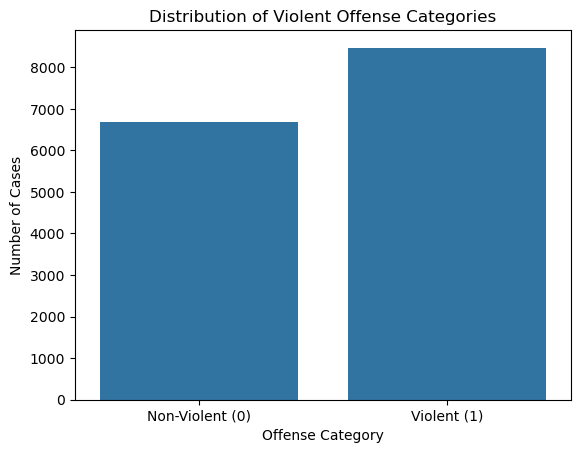

In [20]:
# Check the distribution of the binary labels

print(df_clean.is_violent.value_counts())

label_counts = df_clean["is_violent"].value_counts().sort_index()
label_counts.index = ["Non-Violent (0)", "Violent (1)"]

sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Violent Offense Categories")
plt.ylabel("Number of Cases")
plt.xlabel("Offense Category")
plt.show()


In [21]:
X = df_clean[categorical_features + numerical_features]
y = df_clean["is_violent"]

### 8a. Baseline Model: Minimal Features (`AGE` and `GENDER`)

To establish a realistic starting point, we train a simple classification model using only two features: `AGE` and `GENDER`.

This helps us assess whether basic demographic data alone can provide any meaningful signal in distinguishing violent from non-violent offenses. The performance from this model acts as our baseline to improve upon with more complex feature sets. We use a simple Logistic Regression model to understand how much predictive power these features hold on their own.



In [22]:
# Select minimal features for baseline
baseline_features = ["AGE", "GENDER"]
X_base = df_clean[baseline_features]
y_base = df_clean["is_violent"]


In [23]:
baseline_preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), ["AGE"]),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["GENDER"])
])

In [24]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, stratify=y_base, random_state=21)

baseline_pipeline = Pipeline([
    ("preprocess", baseline_preprocessor),
    ("model", LogisticRegression())
])

baseline_pipeline.fit(X_train_b, y_train_b)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['AGE']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['GENDER'])])),
                ('model', LogisticRegression())])

In [25]:
y_pred_base = baseline_pipeline.predict(X_test_b)
y_proba_base = baseline_pipeline.predict_proba(X_test_b)[:, 1]

print("Baseline Model Results (AGE + GENDER):")
print(classification_report(y_test_b, y_pred_base))
print("ROC AUC Score:", roc_auc_score(y_test_b, y_proba_base))


Baseline Model Results (AGE + GENDER):
              precision    recall  f1-score   support

           0       0.54      0.15      0.24      1671
           1       0.57      0.90      0.70      2118

    accuracy                           0.57      3789
   macro avg       0.55      0.52      0.47      3789
weighted avg       0.56      0.57      0.49      3789

ROC AUC Score: 0.5639686673007122


### Grouped Feature Correlation with `is_violent`

To evaluate how predictive each original feature group is, we compute the average absolute correlation between all one-hot encoded features and the binary target `is_violent`. This helps us identify which features contribute the most signal in the model.


In [26]:
# Apply transformation
X_transformed = preprocessor.fit_transform(X)

# Create DataFrame with encoded feature names
X_transformed_df = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

# Add target variable
X_transformed_df["is_violent"] = df_clean["is_violent"].reset_index(drop=True)


In [27]:
# Compute correlation with the target
X = X_transformed_df.drop(columns="is_violent")
y = X_transformed_df["is_violent"]
feature_corr = X.corrwith(y)

# Group correlations by original feature name (before one-hot)
grouped_corr = {}
for col in feature_corr.index:
    group = col.split("__")[1].split("_")[0]  # Extract top-level feature name
    grouped_corr.setdefault(group, []).append(feature_corr[col])

# Compute average absolute correlation per group
grouped_corr_mean = {k: np.mean(np.abs(v)) for k, v in grouped_corr.items()}
grouped_corr_series = pd.Series(grouped_corr_mean).sort_values(ascending=False)


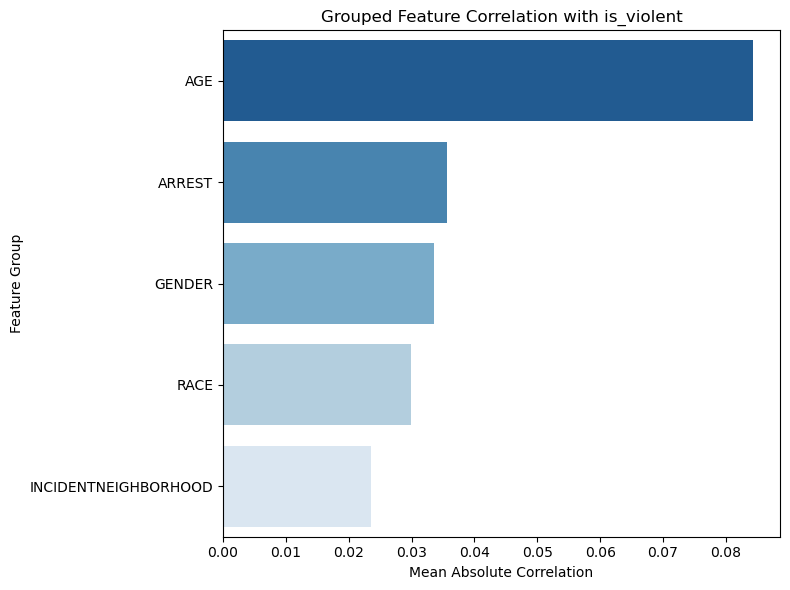

In [28]:
# Plot grouped correlation summary
plt.figure(figsize=(8, 6))
sns.barplot(x=grouped_corr_series.values, y=grouped_corr_series.index, palette="Blues_r")
plt.title("Grouped Feature Correlation with is_violent")
plt.xlabel("Mean Absolute Correlation")
plt.ylabel("Feature Group")
plt.tight_layout()
plt.show()


#### 8b. Final Classification Models with Full Feature Set

We now train and evaluate three classification models using the selected feature set and preprocessing pipeline:
- Logistic Regression
- Random Forest Classifier
- XGBoost Classifier

Each model uses the one-hot encoded categorical variables and scaled numerical variables prepared earlier.  
Performance is evaluated using precision, recall, F1-score, and ROC AUC.


In [29]:
# Use selected features (excluding neighborhood)
X = df_clean[["AGE", "ARREST_HOUR", "GENDER", "INCIDENTNEIGHBORHOOD", "RACE", "ARREST_DAY"]]
y = df_clean["is_violent"]

In [30]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=21)

In [31]:
# Define models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=21),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=21)
}


In [32]:
# Loop through and evaluate each model
for name, model in models.items():
    clf_pipeline = Pipeline([
        ("preprocessing", preprocessor),  # already defined above
        ("model", model)
    ])
    
    clf_pipeline.fit(X_train, y_train)
    y_pred = clf_pipeline.predict(X_test)
    y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

    print(f"Results for {name}")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("=" * 60)


Results for Logistic Regression
              precision    recall  f1-score   support

           0       0.63      0.53      0.57      1671
           1       0.67      0.75      0.71      2118

    accuracy                           0.65      3789
   macro avg       0.65      0.64      0.64      3789
weighted avg       0.65      0.65      0.65      3789

ROC AUC Score: 0.6945039215320619
Results for Random Forest
              precision    recall  f1-score   support

           0       0.63      0.56      0.59      1671
           1       0.68      0.74      0.71      2118

    accuracy                           0.66      3789
   macro avg       0.65      0.65      0.65      3789
weighted avg       0.66      0.66      0.66      3789

ROC AUC Score: 0.7063683996679455
Results for XGBoost
              precision    recall  f1-score   support

           0       0.66      0.56      0.60      1671
           1       0.69      0.77      0.73      2118

    accuracy                        

###  Cross-Validation of Classifiers

To ensure generalizability and avoid overfitting, we apply 5-fold stratified cross-validation on all three classifiers.  
This gives us more reliable performance metrics across different splits of the data.


In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
scorers = {
    "Accuracy": "accuracy",
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "F1": make_scorer(f1_score),
    "ROC AUC": "roc_auc"
}

In [34]:
# Run CV using same preprocessor and model dictionary
for name, model in models.items():
    print(f"Cross-Validation Results for {name}")
    for metric_name, scorer in scorers.items():
        scores = cross_val_score(
            Pipeline([
                ("preprocessor", preprocessor),
                ("model", model)
            ]),
            X, y,
            scoring=scorer,
            cv=cv
        )
        print(f"{metric_name}: {scores.mean():.3f} ± {scores.std():.3f}")
    print("=" * 60)


Cross-Validation Results for Logistic Regression
Accuracy: 0.645 ± 0.006
Precision: 0.660 ± 0.006
Recall: 0.753 ± 0.006
F1: 0.703 ± 0.004
ROC AUC: 0.686 ± 0.005
Cross-Validation Results for Random Forest
Accuracy: 0.655 ± 0.005
Precision: 0.677 ± 0.007
Recall: 0.735 ± 0.009
F1: 0.704 ± 0.003
ROC AUC: 0.700 ± 0.009
Cross-Validation Results for XGBoost
Accuracy: 0.669 ± 0.007
Precision: 0.683 ± 0.006
Recall: 0.761 ± 0.008
F1: 0.720 ± 0.006
ROC AUC: 0.715 ± 0.006


### ROC Curve Comparison: Cross-Validation vs. Test

We compare ROC curves for Logistic Regression, Random Forest, and XGBoost across:
- **Cross-validation folds** (left)
- **Held-out test set** (right)

This visualization highlights model consistency and robustness in identifying violent offenses.


In [35]:

# Store FPR/TPR results
roc_curves_test = {}
roc_curves_cv = {}

trained_models = {}  # Optional: to save fitted test set models


In [36]:
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    # Fit once on train and store test ROC
    pipe.fit(X_train, y_train)
    trained_models[name] = pipe  # store for reuse
    y_proba_test = pipe.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
    roc_curves_test[name] = (fpr_test, tpr_test)

    # Cross-validated predicted probabilities
    y_proba_cv = cross_val_predict(pipe, X, y, cv=5, method="predict_proba")[:, 1]
    fpr_cv, tpr_cv, _ = roc_curve(y, y_proba_cv)
    roc_curves_cv[name] = (fpr_cv, tpr_cv)


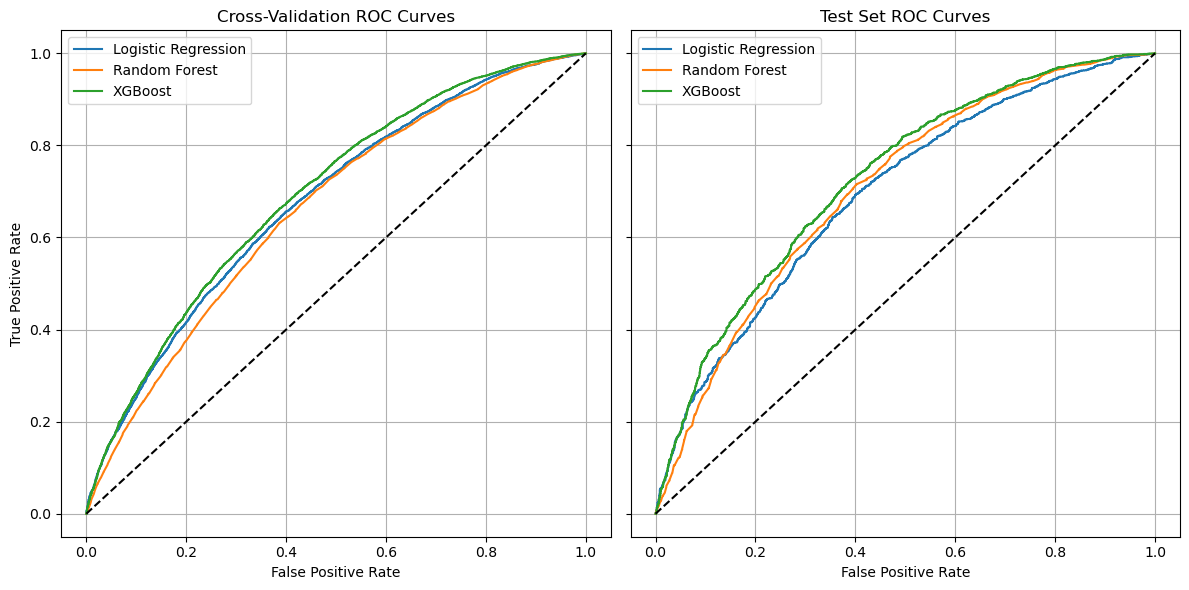

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Cross-validation ROC plot
for name in roc_curves_cv:
    axes[0].plot(roc_curves_cv[name][0], roc_curves_cv[name][1], label=name)
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title("Cross-Validation ROC Curves")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(True)

# Test set ROC plot
for name in roc_curves_test:
    axes[1].plot(roc_curves_test[name][0], roc_curves_test[name][1], label=name)
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title("Test Set ROC Curves")
axes[1].set_xlabel("False Positive Rate")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### ROC Curve Analysis: Cross-Validation vs. Test Performance

To evaluate and compare model performance, we plotted the Receiver Operating Characteristic (ROC) curves for:
- **5-fold Cross-Validation**: average behavior across folds  
- **Held-out Test Set**: model performance on unseen data

Each ROC curve shows the trade-off between the **True Positive Rate (TPR)** and **False Positive Rate (FPR)** across classification thresholds.

#### Key Observations:
- **XGBoost** consistently outperformed the other models, achieving the highest ROC AUC in both cross-validation (**0.715**) and test set evaluation (**0.726**). Its ROC curve remains above the others across most thresholds.
- **Random Forest** closely followed XGBoost, with slightly lower AUC values (CV: **0.700**, Test: **0.706**), demonstrating strong generalization.
- **Logistic Regression** underperformed relative to tree-based models, with lower AUC scores (CV: **0.686**, Test: **0.695**), suggesting limited capacity to capture non-linear relationships.

#### Conclusion:
Based on ROC curve shapes and AUC values, **XGBoost** was selected as the best-performing model for predicting violent offenses. It offers the most reliable separation between violent and non-violent classes under varying thresholds.


In [38]:
# Refit XGBoost with pipeline
xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

xgb_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['GENDER', 'RACE',
                                                   'INCIDENTNEIGHBORHOOD',
                                                   'ARREST_DAY']),
                                                 ('num', StandardScaler(),
                                                  ['AGE', 'ARREST_HOUR'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               col...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [39]:
# Example: define your numeric and categorical columns
numeric_cols = ["AGE", "ARREST_HOUR"]
categorical_cols = ["RACE", "GENDER", "ARREST_DAY"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

# Assuming you’ve already split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, ...)


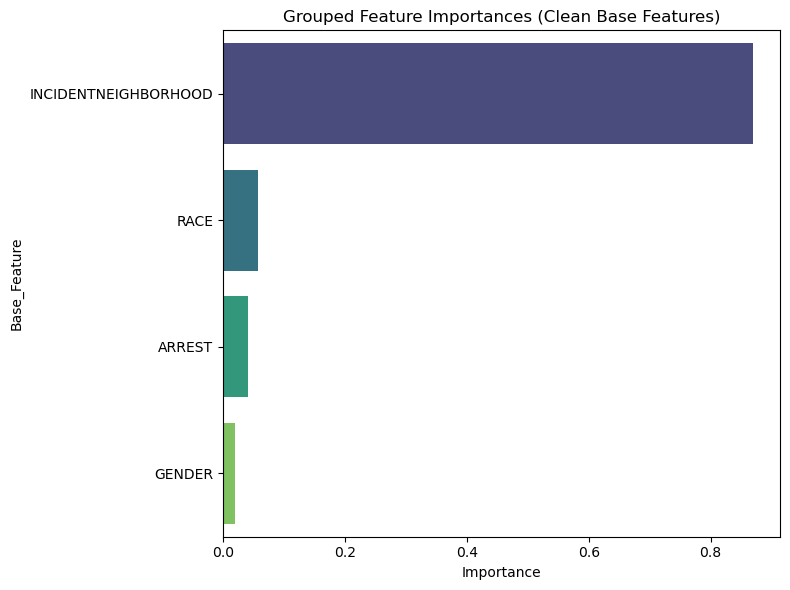

In [40]:
# Recompute importance values
importances = xgb_pipe.named_steps["model"].feature_importances_
feature_names = xgb_pipe.named_steps["preprocessor"].get_feature_names_out()
feat_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Extract base feature name from OneHotEncoder pattern
feat_imp_df["Base_Feature"] = feat_imp_df["Feature"].str.extract(r"cat__(.*?)_")  # categorical
feat_imp_df.loc[feat_imp_df["Base_Feature"].isnull(), "Base_Feature"] = feat_imp_df["Feature"]  # numeric untouched

# Group by base feature
summary = feat_imp_df.groupby("Base_Feature")["Importance"].sum().reset_index()
summary = summary.sort_values("Importance", ascending=False)

# Optional: Filter low-importance groups
summary = summary[summary["Importance"] > 0.01]

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=summary, x="Importance", y="Base_Feature", palette="viridis")
plt.title("Grouped Feature Importances (Clean Base Features)")
plt.tight_layout()
plt.show()


> **Note**: The grouped feature importance chart aggregates one-hot encoded variables under their original base names. For example, all `ARREST_DAY_*` and `ARREST_HOUR` variables are grouped under `ARREST`. This may visually mask the individual influence of variables like `ARREST_DAY_Sunday`, but they are included in the total bar height for the `ARREST` group if they were part of the model.


### Interpretation: Grouped Feature Importances

This plot shows the **relative importance of grouped input features** in the final predictive model, using clean base features. Each bar represents the **aggregate importance** of all encoded variables related to a specific category (e.g., all one-hot-encoded gender or neighborhood variables).

####  Key Insights:

- **INCIDENTNEIGHBORHOOD** is by far the most influential predictor, contributing over **85% of the total feature importance**. This suggests that the **location of the incident** plays a dominant role in predicting whether an arrest is classified as violent or not.
- **RACE** and **ARREST (time-based features)** have **modest contributions**, indicating some predictive value but far less than location.
- **GENDER** has minimal influence on the model, contributing only a small fraction to the decision-making process.

<Figure size 600x500 with 0 Axes>

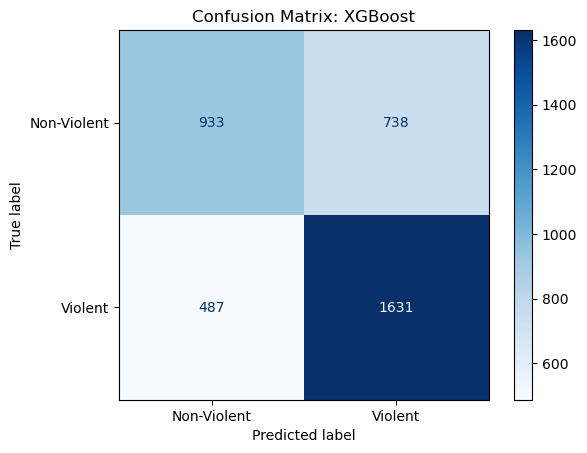

In [41]:
y_pred = xgb_pipe.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Violent", "Violent"])
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: XGBoost")
plt.grid(False)
plt.show()

### Interpretation of XGBoost Confusion Matrix

The confusion matrix summarizes the model’s predictions on the test set for classifying arrests as **Violent** or **Non-Violent**.

- **True Positives (Bottom-Right, 1631):** The model correctly predicted 1,631 violent arrests.
- **True Negatives (Top-Left, 933):** The model correctly predicted 933 non-violent arrests.
- **False Positives (Top-Right, 738):** The model incorrectly labeled 738 non-violent arrests as violent.
- **False Negatives (Bottom-Left, 487):** The model missed 487 violent arrests by classifying them as non-violent.

This performance indicates that the model is relatively effective at detecting violent incidents (with a high number of true positives), but it also makes a notable number of errors:
- **False negatives** (violent crimes missed) are particularly concerning from a public safety standpoint.
- **False positives** (non-violent crimes flagged as violent) may raise fairness or over-policing concerns.

**Future Considerations:** Balancing precision and recall or adjusting the decision threshold might help improve model performance and fairness.


In [42]:
# Get predicted labels from your final trained pipeline (e.g., XGBoost)
y_pred = xgb_pipe.predict(X_test)

# Copy test set into a new DataFrame for analysis
df_test = X_test.copy()
df_test["y_true"] = y_test
df_test["y_pred"] = y_pred

# Replace race and gender codes directly in df_test
df_test["RACE"] = df_test["RACE"].replace({
    "B": "Black", "W": "White", "H": "Hispanic",
    "A": "Asian", "O": "Other", "U": "Unknown"
})
df_test["GENDER"] = df_test["GENDER"].replace({
    "M": "Male", "F": "Female", "U": "Unknown"
})


In [43]:
def fairness_audit(df, group_col):
    """
    Evaluates fairness metrics (Accuracy, Precision, Recall, F1) 
    for each group within the specified column.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'y_true' and 'y_pred' columns.
    group_col (str): Column name to group by (e.g., 'RACE', 'GENDER').

    Returns:
    pd.DataFrame: Summary table of fairness metrics per group.
    """
    results = []

    for group in df[group_col].unique():
        group_df = df[df[group_col] == group]
        if len(group_df) == 0:
            continue
        
        acc = accuracy_score(group_df["y_true"], group_df["y_pred"])
        prec = precision_score(group_df["y_true"], group_df["y_pred"], zero_division=0)
        rec = recall_score(group_df["y_true"], group_df["y_pred"], zero_division=0)
        f1 = f1_score(group_df["y_true"], group_df["y_pred"], zero_division=0)

        results.append({
            group_col: group,
            "Support": len(group_df),
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-score": f1
        })

    return pd.DataFrame(results).sort_values("Support", ascending=False)



In [44]:
# Run audits by race and gender
race_fairness = fairness_audit(df_test, "RACE")
gender_fairness = fairness_audit(df_test, "GENDER")

print("Fairness by Race:")
print(race_fairness)

print("\nFairness by Gender:")
print(gender_fairness)

Fairness by Race:
       RACE  Support  Accuracy  Precision    Recall  F1-score
0     Black     2569  0.683534   0.699581  0.789865  0.741987
1     White     1095  0.659361   0.654762  0.693694  0.673666
2  Hispanic       48  0.687500   0.674419  0.966667  0.794521
4     Other       44  0.795455   0.813953  0.972222  0.886076
3   Unknown       25  0.560000   0.529412  0.750000  0.620690
5     Asian        8  0.500000   0.571429  0.800000  0.666667

Fairness by Gender:
    GENDER  Support  Accuracy  Precision    Recall  F1-score
0     Male     2813  0.663704   0.669778  0.751309  0.708205
1   Female      972  0.712963   0.737003  0.818336  0.775543
2  Unknown        4  1.000000   1.000000  1.000000  1.000000


In [45]:
def plot_fairness_line(fairness_df, group_col, metrics=["Recall", "F1-score"]):
    """
    Plots a line chart showing fairness metrics (Recall and F1-score) 
    for each group in the specified column.

    Parameters:
    fairness_df (pd.DataFrame): DataFrame containing fairness metrics per group.
    group_col (str): Column name to group by (e.g., 'RACE', 'GENDER').
    metrics (list): List of metrics to plot (default: ['Recall', 'F1-score']).

    Returns:
    None
    """
    df_long = fairness_df.melt(id_vars=[group_col, "Support"], 
                                value_vars=metrics, 
                                var_name="Metric", value_name="Score")

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_long, x=group_col, y="Score", hue="Metric", marker="o")
    plt.title(f"Fairness Audit (Line Plot) by {group_col}")
    plt.ylim(0, 1.05)
    plt.ylabel("Score")
    plt.xlabel(group_col)
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


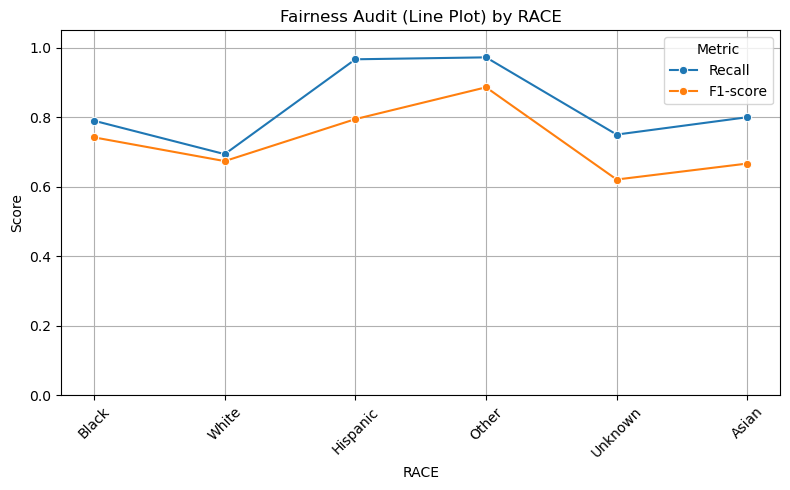

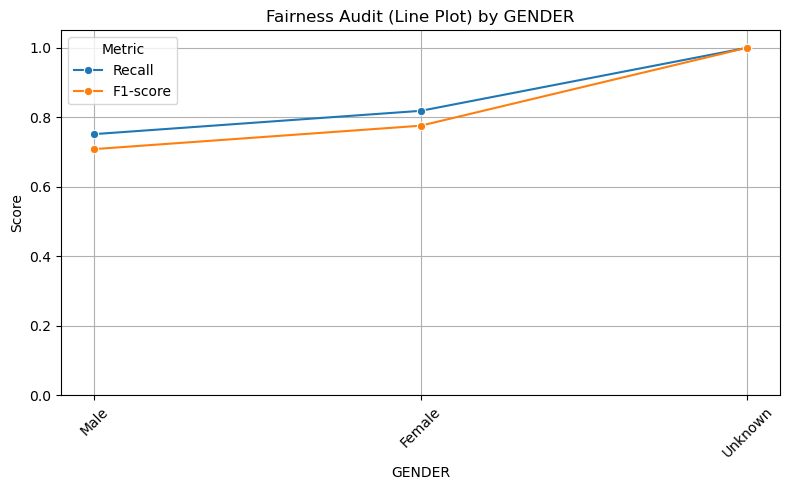

In [46]:
plot_fairness_line(race_fairness, "RACE")
plot_fairness_line(gender_fairness, "GENDER")


### Fairness Audit Interpretation

##### Performance by RACE

The fairness audit line plot for **RACE** shows noticeable variation in **Recall** and **F1-score** across different racial groups:

- **Hispanic** and **Other** groups have very high recall (close to 1.0), suggesting the model is highly sensitive to detecting violent arrests in these subgroups.
- **Black** and **Asian** groups show moderately strong performance, with recall and F1-scores around 0.75–0.80.
- **White** and especially **Unknown** race categories perform comparatively worse, with lower recall and F1-scores near 0.65–0.70.

This disparity indicates **potential racial bias** in the model's predictions, which could result from imbalanced data, underrepresentation of certain subgroups, or inherent feature correlations. Additional steps like stratified sampling, bias mitigation techniques, or fairness-aware modeling might be warranted.

---

##### Performance by GENDER

The audit for **GENDER** shows more **consistent performance** across groups:

- Both **Male** and **Female** groups have recall and F1-scores in the 0.75–0.85 range.
- The **Unknown** gender group shows perfect performance (score = 1.0), which is likely due to a very small sample size or an easily separable subset. This result should be interpreted with caution.

This suggests that the model is **more fair across gender lines** compared to race. However, the perfect performance for the "Unknown" category may reflect data artifacts or imbalance and should be further inspected.

---

##### Conclusion

- **Gender fairness is generally acceptable**, with balanced performance metrics.
- **Racial fairness shows disparities**, particularly lower performance for White and Unknown race categories.
- **Future Considerations**: Consider subgroup rebalancing, model regularization, and fairness-aware evaluation to address these gaps and ensure equitable performance.


### 9. Clustering and Geospatial Risk Mapping
We apply unsupervised learning (DBSCAN) to group spatial clusters of arrests in Pittsburgh.  
This helps us identify areas with distinct crime characteristics.

We'll categorize offenses, cluster based on location, and assign a danger score for mapping.

In [47]:
# Extract primary offense and offense type
df_split = df["OFFENSES"].astype(str).str.split("/", expand=True)
df["OFFENSE_PRIMARY"] = df_split[0].str.strip()

def map_offense_type(offense):
    """
    Maps offense descriptions to offense types based on keyword matching.

    Parameters:
    offense (str): A string describing the offense.

    Returns:
    str: The offense type (e.g., 'Violent', 'Property', 'Drug-Related', 'Public Order', 'Other').
    """
    offense = str(offense).lower()

    if re.search(r"assault|robbery|homicide", offense):
        return "Violent"
    elif re.search(r"theft|burglary|mischief", offense):
        return "Property"
    elif re.search(r"drug|controlled substance|possession", offense):
        return "Drug-Related"
    elif re.search(r"disorderly|drunkenness|obstructing", offense):
        return "Public Order"
    else:
        return "Other"


df["OFFENSE_TYPE"] = df["OFFENSE_PRIMARY"].apply(map_offense_type)

#### 9a. Apply DBSCAN to Latitude/Longitude
We use X and Y coordinates of arrests, scaled appropriately, to detect spatially dense crime clusters.


In [48]:
coords = df[['X', 'Y']].dropna()
scaled_coords = StandardScaler().fit_transform(coords)

cluster_model = DBSCAN(eps=0.01, min_samples=30)
df["GEO_CLUSTER"] = cluster_model.fit_predict(scaled_coords)

### 9b. Summarize Top Offense Type and Violence Rate per Cluster
For each spatial cluster, we compute:
- Number of crimes per type
- Top offense type
- % of violent crimes

In [49]:
crime_summary = df.groupby(["GEO_CLUSTER", "OFFENSE_TYPE"]).size().unstack(fill_value=0)
crime_summary["TOP_OFFENSE"] = crime_summary.idxmax(axis=1)

offense_cols = [col for col in crime_summary.columns if col != "TOP_OFFENSE"]
crime_summary["VIOLENT_PCT"] = crime_summary.get("Violent", 0) / crime_summary[offense_cols].sum(axis=1)

df = df.merge(crime_summary["TOP_OFFENSE"], left_on="GEO_CLUSTER", right_index=True)
df.rename(columns={"TOP_OFFENSE": "CLUSTER_CRIME_TYPE"}, inplace=True)


### 9c. Assign Human-Readable Danger Levels
Based on the cluster's top crime type, we define qualitative danger labels and numeric scores.

In [50]:
def classify_danger(row):
    """
    Classifies danger level based on offense type.

    Parameters:
    row (pd.Series): A row of the DataFrame containing 'CLUSTER_CRIME_TYPE'.

    Returns:
    str: The danger level (e.g., 'High Danger', 'Medium', 'Caution', 'Low').
    """
    val = str(row.get("CLUSTER_CRIME_TYPE", "")).strip()
    if val == "Violent":
        return "High Danger"
    elif val == "Property":
        return "Medium"
    elif val == "Drug-Related":
        return "Caution"
    else:
        return "Low"


df["DANGER_LEVEL"] = df.apply(classify_danger, axis=1)
df["DANGER_LEVEL"] = df["DANGER_LEVEL"].fillna("Low")

# Map danger levels to numerical scores for choropleth shading
danger_score = {"Low": 0, "Caution": 1, "Medium": 2, "High Danger": 3}
df["DANGER_SCORE"] = df["DANGER_LEVEL"].map(danger_score)


### 9d. Compute Neighborhood-Level Danger Scores
We aggregate by neighborhood to calculate:
- Average Danger Score
- Total Danger Score
- Arrest Count


In [51]:
zone_stats = df.groupby("INCIDENTNEIGHBORHOOD").agg({
    "DANGER_SCORE": ["mean", "sum", "count"]
}).reset_index()
zone_stats.columns = ["Neighborhood", "Avg_Danger", "Total_Danger", "Arrest_Count"]


## 9e. Choropleth + Marker Map
This map shows clusters with colored markers and overlays a choropleth of average danger scores by neighborhood.

In [52]:
map_center = [df["Y"].mean(), df["X"].mean()]
m = folium.Map(location=map_center, zoom_start=12)

with open("pittsburghpaneighborhoods.geojson", "r") as f:
    geo_data = json.load(f)

choropleth = folium.Choropleth(
    geo_data=geo_data,
    name="Choropleth - Avg Score",
    data=zone_stats,
    columns=["Neighborhood", "Avg_Danger"],
    key_on="feature.properties.hood",
    fill_color="YlOrRd",
    fill_opacity=0.6,
    line_opacity=0.5,
    legend_name="Average Danger Score by Neighborhood").add_to(m)

# Add neighborhood name tooltip
folium.GeoJson(
    geo_data,
    style_function=lambda x: {"fillColor": "transparent", "color": "transparent", "weight": 0},
    tooltip=GeoJsonTooltip(fields=["hood"], aliases=["Neighborhood:"], sticky=False)
).add_to(m)


marker_cluster = MarkerCluster().add_to(m)
color_map = {
    "High Danger": "darkred",
    "Medium": "orange",
    "Caution": "blue",
    "Low": "green"
}

for _, row in df[df["GEO_CLUSTER"] != -1].iterrows():
    folium.Marker(
        location=[row["Y"], row["X"]],
        icon=BeautifyIcon(
            icon_shape="marker",
            border_color=color_map.get(row["DANGER_LEVEL"], "gray"),
            text_color="white",
            background_color=color_map.get(row["DANGER_LEVEL"], "gray"),
            number='⚠' if row["DANGER_LEVEL"] == "High Danger" else ''
        ),
        tooltip=f"{row['CLUSTER_CRIME_TYPE']} | {row['DANGER_LEVEL']}"
    ).add_to(marker_cluster)


folium.LayerControl().add_to(m)
m.save("choropleth_avg_danger_map.html")
print("Saved map with choropleth (total & avg) + markers: choropleth_avg_danger_map.html")


Saved map with choropleth (total & avg) + markers: choropleth_avg_danger_map.html


#### Map Interpretation: Geospatial Clustering of Arrest Patterns in Pittsburgh (2020–2023)
This choropleth map output we get above visualizes spatial clusters of arrests across Pittsburgh neighborhoods using the DBSCAN clustering algorithm.

Neighborhood Coloring (Choropleth Layer): Each neighborhood is shaded based on its average danger score, derived from the dominant crime types in that area. A darker red shade indicates a higher concentration of severe crimes (e.g., violent offenses), while lighter yellow-green areas represent lower-risk neighborhoods.

Circle Labels: The numeric labels (e.g., 263, 104, 91) represent the total number of arrests in that neighborhood, providing insight into the volume of criminal activity irrespective of type.

Clustered Pin Markers: Arrest clusters are marked and color-coded based on the predominant offense type:

🔴 Red: High Danger – primarily violent crimes.

🟠 Orange: Medium Danger – property-related crimes.

🔵 Blue: Caution – drug-related offenses.

🟢 Green: Low Danger – minor or public order offenses.

Neighborhood Hover Feature: Interactive tooltips reveal the neighborhood name for easy spatial reference.

**Some Examples of Interpretations of the map:**

Crafton Heights shows multiple clusters of violent crimes and is shaded dark red, indicating a high average danger score with a lower arrest count (56) shaded red.

Shadyside have high total arrests (263 and 104, respectively) and significant clustering of property-related crimes and has medium danger score shaded orange.

North Oakland is lighter shaded, indicating relatively lower risk, with clusters labeled as “Low Danger” and is shaded green.